In [66]:
import argparse, json, time, random
import hashlib, torch, math, pathlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.animation as animation
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
import importlib, importlib.util, os
from matplotlib.ticker import MaxNLocator

targetinput_color = "#006838"
distractor_color = "#97211F"
analyze_network = "final"  # options: "best", "final", <parameter update step no>
noise_amplitude = 0.1  # if run analyses with noise, noise amplitude
distractor_probability = 0.0
show_figures = True  # True if running in jupyter notebook; False if running a .py file
running_from_data = True # True if code is running in the data folder next to the model.pth. if false, must run from training file

directories = [
    #f"data/hdinversionCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    f"data/hdreshuffle_fCTRNN_2DIR1O_dr100_n0.1_la0_sa130_e1_dp1.0_r0/",
    #f"data/hdgatingCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/",
    #f"data/hdratioCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r0/"
    #f"data/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa0_sf1_e1_dp0.0_rTEST_CORRELATIONS/"
]

figure_dir_prefix = "paper_figures/example_networks_gifs/"

In [67]:
def _calc_pref_ave(units_i, timestep_from, timestep_to, to=1, data=None, round_prefs=False, smoothing_constant=0.01):
    """
        Calculate the preferred direction of a given neuron across a window given
    """
    if data is None: data = ao_data
    w = torch.sum(data[timestep_from:timestep_to][:, units_i], dim=(0, 4-to)).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+smoothing_constant)) * 180 / np.pi
    a[a<0] = a[a<0]+360
    a = torch.tensor(a)
    if round_prefs: a = torch.round(a)
    return a

def generate_gif_animation(trial=48, ring_radius = 5, anim_noise_level = 0.05, distractor_angle = 0, skip_units = 1, gate=False, ring=True, input=True, readout=True): 
    print(f"Input angle: {np.arange(100)[trial]/100*360}\nDistractor angle: {distractor_angle}")

    def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=100, distractor_probability=1):
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        for direction1 in np.arange(resolution)/resolution*360:
            for direction2 in [distractor_angle]:
                i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
        return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=1.0)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * anim_noise_level
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    ####################### GATE UNITS
    
    def update(t):
        ax.clear()
    
        r = ring_radius
        units_i = torch.tensor([x for x in range(100) if x not in R1_i])[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t2-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*3
            ax.bar3d(x, y, z, dx, dy, dz, color="gray")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    if gate:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
        ani.save(f'{figure_dir_prefix}{directory[5:-1]}_gate.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
        plt.show()
    
    ###################### RING UITS
    
    def update(t):
        ax.clear()
    
        r = ring_radius
        units_i = R1_i[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t3-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*3
            ax.bar3d(x, y, z, dx, dy, dz, color="gray")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    if ring:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
        ani.save(f'{figure_dir_prefix}{directory[5:-1]}_ring.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
        plt.show()
    
    ##################### INPUT
    
    def update(t):
        ax.clear()
    
        r = ring_radius
        units_i = np.arange(net_size)[::skip_units*2]
        n_bars = len(units_i)
        if n_bars>0:
            theta = units_i / net_size * 360
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_input[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*3
            ax.bar3d(x, y, z, dx, dy, dz, color="lightgray")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    if input:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111, projection='3d')
        ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
        ani.save(f'{figure_dir_prefix}{directory[5:-1]}_input.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
        plt.show()
    
    ######################### READOUT
    
    def update(t):
        ax.clear()
        angle = (task.convert_sincos_to_angles(ao_output, t, t+1)[0][trial]).item()
        if angle < 0: angle += 360 # keep the angle between 0 and 360
        ax.text(0, +0.12, f"readout: $\\theta = {angle:.1f}$")
       # ax.text(0, 0, f"$\\theta = {angle:.1f}$°", fontweight=200)
        ax.set_xlim(-0, .3)
        ax.set_ylim(-.3, .3)
        ax.axis('off')
    if readout:
        fig = plt.figure(figsize=(2, 2))
        ax = fig.add_subplot(111)
        ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
        ani.save(f'{figure_dir_prefix}{directory[5:-1]}_readout.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
        plt.show()

def generate_gif_animation_inv(trial=50, ring_radius = 5, anim_noise_level = 0.05, distractor_angle = 270, skip_units = 1):
    print(f"Input angle: {np.arange(100)[trial]/100*360}\nDistractor angle: {distractor_angle}")
    stable_color = "#006838"
    inv_color = "#97211F"
    
    def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=100, distractor_probability=1):
        batch = []  # inputs in the batch
        batch_labels = []  # target outputs in the batch
        output_masks = []  # masks in the batch
        for direction1 in np.arange(resolution)/resolution*360:
            for direction2 in [distractor_angle]:
                i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
        return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=1.0)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * anim_noise_level
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    ######################### ALL RING UNTIS
    
    def update(t, trial=50):
        ax.clear()
    
        r = ring_radius
        units_i = np.arange(55)[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t5-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*2
            ax.bar3d(x, y, z, dx, dy, dz, color=stable_color, alpha=0.5, zorder=1)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
        
        units_i = np.arange(55, 100)[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t5-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*2
            ax.bar3d(x, y, z, dx, dy, dz, color=inv_color, alpha=0.5, zorder=0)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_ring.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()
    
    ######################## ONLY STABLE UNITS
    
    def update(t, trial=50):
        ax.clear()
    
        r = ring_radius
        units_i = np.arange(55)[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t5-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*2
            ax.bar3d(x, y, z, dx, dy, dz, color=stable_color)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_stableonly.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()
    
    ######################## ONLY INVERTING UNITS
    
    def update(t, trial=50):
        ax.clear()
    
        r = ring_radius
        units_i = np.arange(55, 100)[::skip_units]
        n_bars = len(units_i)
        if n_bars>0:
            theta = calc_pref(units_i, t5-1, to=1)
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*2
            ax.bar3d(x, y, z, dx, dy, dz, color=inv_color)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_invonly.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()

    ##################### INPUT
    
    def update(t):
        ax.clear()
    
        r = ring_radius
        units_i = np.arange(net_size)[::skip_units*2]
        n_bars = len(units_i)
        if n_bars>0:
            theta = units_i / net_size * 360
            x = np.cos(theta*np.pi/180)*r
            y = np.sin(theta*np.pi/180)*r
            z = np.zeros_like(x)
            dx = dy = 0.5 * np.ones_like(z)
            dz = torch.maximum(ao_input[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*3
            ax.bar3d(x, y, z, dx, dy, dz, color="lightgray")
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.axis('off')
        ax.set_zlim(0, 5)
        ax.set_xlim(-r, r)
        ax.set_ylim(-r, r)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_input.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()
    
    ######################### READOUT
    
    def update(t):
        ax.clear()
        angle = (task.convert_sincos_to_angles(ao_output, t, t+1)[0][trial]).item()
        if angle < 0: angle += 360 # keep the angle between 0 and 360
        ax.text(0, +0.12, f"readout: $\\theta = {angle:.1f}$")
       # ax.text(0, 0, f"$\\theta = {angle:.1f}$°", fontweight=200)
        ax.set_xlim(-0, .3)
        ax.set_ylim(-.3, .3)
        ax.axis('off')
    
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(111)
    ani = FuncAnimation(fig, update, frames=range(0, t6-1), repeat=True)
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_readout.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()

def create_task_progression_animation(delay0, delay1, delay2, show_direction_for, show_cue_for):
    # Calculate the total time
    total_time = 2 * show_direction_for + show_cue_for + delay0 + delay1 + delay2
    
    # Create figure and axis with a buffer space for labels
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.set_xlim(0, total_time)
    ax.set_ylim(0, 1)
    #fig.subplots_adjust(top=0.8)  # Adjust the top space to make room for text labels
    ax.axis('off')  # No axis for a cleaner look

    # Define the patches with the correct intervals
    patches = {
        'delay0': plt.Rectangle((0, 0), delay0, 1, fc='lightgray', label='delay0'),
        'show_direction_1': plt.Rectangle((delay0, 0), show_direction_for, 1, fc='grey', label='show_direction_1'),
        'delay1': plt.Rectangle((delay0 + show_direction_for, 0), delay1, 1, fc='lightgray', label='delay1'),
        'show_direction_2': plt.Rectangle((delay0 + show_direction_for + delay1, 0), show_direction_for, 1, fc='grey', label='show_direction_2'),
        'delay2': plt.Rectangle((delay0 + show_direction_for * 2 + delay1, 0), delay2, 1, fc='lightgray', label='delay2'),
        'show_cue': plt.Rectangle((delay0 + show_direction_for * 2 + delay1 + delay2, 0), show_cue_for, 1, fc='black', label='show_cue'),
    }

    # Add patches to the axis
    for patch in patches.values():
        ax.add_patch(patch)

    # Create pointer
    pointer, = ax.plot([], [], lw=20, color='black')

    # Initialize the pointer's position
    def init():
        pointer.set_data([], [])
        return pointer,

    # Update the pointer to the current frame/time
    def animate(frame):
        x = frame / 10.0
        pointer.set_data([x, x], [0, 1])
        return pointer,

    # Creating the animation with the pointer
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=int(total_time * 10), interval=100, blit=True)

    # Save the new animation as an MP4 file with the pointer
    # Apply tight_layout to adjust the spacing
    fig.tight_layout()
    mp4_file_with_pointer = f'{figure_dir_prefix}{directory[5:-1]}_taskprog.mp4'
    ani.save(mp4_file_with_pointer, writer='ffmpeg', fps=60, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])

    return mp4_file_with_pointer  # Return the new file path for the user to download

In [68]:
def generate_functionalconnectivity_animation():
    global R1_i
    from scipy.optimize import curve_fit
    lim = 0.1
    sd = False
    # function that will be fit to the averaged connection weights
    def cosine_fit(x, a, b):
        return a * np.cos(x * np.pi / 180) + b
    
    def get_connplot_graph(units1_id=None, unit1_pref=None, units2_id=None, unit2_pref=None, sm=0):
        weight_matrix = None  # different models may store weights differently
        try:
            weight_matrix = model.fc_h2ah.weight
        except:
            weight_matrix = model.W_h_ah
        distances_weights = {}
        distances = []
        weights = []
        for i in range(len(units1_id)):
            for j in range(len(units2_id)):
                for k in range(-sm // 2, sm // 2 + 1):
                    if j == i: continue
                    diff = (unit2_pref[j] - unit1_pref[i]).item()
                    if diff > 180: diff -= 360
                    if diff < -180: diff += 360
                    diff += k
                    w_ij = weight_matrix[units2_id[j], units1_id[i]]
                    distances.append(diff)
                    weights.append(w_ij.item())
        return np.array(distances), np.array(weights)
    
    def get_connplot_iu_graph(units_id, unit_pref, sm=0):
        weight_matrix = None  # different models may store weights differently
        try:
            weight_matrix = model.fc_x2ah.weight
        except:
            weight_matrix = model.W_x_ah
        distances_weights = {}
        distances = []
        weights = []
        for i in range(len(units_id)):
            for j in range(task_parameters["input_direction_units"]):
                for k in range(-sm // 2, sm // 2 + 1):
                    # if j == i: continue
                    diff = (unit_pref[i] - round(360 * j / task_parameters["input_direction_units"])).item()
                    if diff > 180: diff -= 360
                    if diff < -180: diff += 360
                    diff += k
    
                    w_ij = weight_matrix[units_id[i], j]
                    distances.append(diff)
                    weights.append(w_ij.item())
        return np.array(distances), np.array(weights)
    
    def plot_weights(timestep_from, timestep_to, ax, weights='input', color="green", lim=0.1, fit_curves=True, ax_i=-1):
        if weights=='input':
            x, y = get_connplot_iu_graph(R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1))
        elif weights=='recurrent':
            x, y = get_connplot_graph(R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1), R1_i, _calc_pref_ave(R1_i, timestep_from, timestep_to, to=1))
        bins = np.linspace(-180, 180, 20)
        x_binned = []
        y_binned = []
        sem_binned = []
        bin_ids = np.digitize(x, bins)
        for i in range(1, len(bins)):
            x_binned.append(np.mean(x[bin_ids == i]))
            y_binned.append(np.mean(y[bin_ids == i]))
            sem_binned.append(scipy.stats.sem(y[bin_ids == i]) if not sd else np.std(y[bin_ids == i]))
        x_binned, y_binned, sem_binned = np.array(x_binned), np.array(y_binned), np.array(sem_binned) * 1.96
        ax.axhline(y=0.0, color='gray', linestyle='--', linewidth=2)
        ax.fill_between(x_binned, y_binned - sem_binned, y_binned + sem_binned, color=color, alpha=0.3, linewidth=0)
        ax.plot(x_binned, y_binned, "-", color=color, linewidth=3)
        ax.set_xlim(-180, 180)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-lim * 1.1, lim * 1.1)
        ax.set_yticks([-lim, 0, lim])
        ax.set_yticks([])
        ax.set_xticks([-180, 0, 180])
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d°'))
        ax.set_yticks([-lim, 0, lim])
    
        if not np.isfinite(x_binned).all():
            print("x")
            print(x_binned)
            print(weights)
        if not np.isfinite(y_binned).all():
            print("y")
            print(y_binned)
        params, covariance = curve_fit(cosine_fit, x_binned, y_binned)
        y_fit = cosine_fit(x_binned, *params)
        if fit_curves:
            ax.plot(x_binned, y_fit, "--", color=color, linewidth=3, label=f"$a = {params[0]:.3f}$")
        return params
    
    def update(t):
        ax.clear()
        if t>t1: 
            plot_weights(t, t+1, ax, weights='input', color="green", lim=lim, fit_curves=True)
            ax.legend()
        ax.set_ylabel("weight between input\nand recurrent unit")
        ax.set_xlabel("preferred angle difference\nbetween two units")
    # Setup figure and axis for the animation
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    fig.set_tight_layout(True)
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    # Create the animation
    ani = FuncAnimation(fig, update, frames=range(t6-2), repeat=True)  # Adjust range as needed
    # Save the animation
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_funcconn_in.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()
    
    def update(t):
        ax.clear()
        if t>t1: 
            plot_weights(t, t+1, ax, weights='recurrent', color="black", lim=lim, fit_curves=True)
            ax.legend()
        ax.set_ylabel("weight between two\nrecurrent units")
        ax.set_xlabel("preferred angle difference\nbetween two units")
    # Setup figure and axis for the animation
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    fig.set_tight_layout(True)
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    # Create the animation
    ani = FuncAnimation(fig, update, frames=range(t6-2), repeat=True)  # Adjust range as needed
    # Save the animation
    ani.save(f'{figure_dir_prefix}{directory[5:-1]}_funcconn_rec.mp4', writer='ffmpeg', fps=6, dpi=300, bitrate=1600, extra_args=['-vcodec', 'libx264', '-crf', '22'])
    plt.show()

data/hdreshuffle_fCTRNN_2DIR1O_dr100_n0.1_la0_sa130_e1_dp1.0_r0/
mean squared error (deg):  8.84057215017121


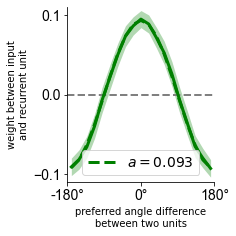

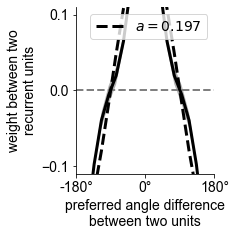

In [69]:
for _directory in directories:
    print(_directory)
    directory = _directory
    
    # Define the file path and module name
    file_path = directory + "task_and_training.py"  # Change this to your file's path
    module_name = 'task_and_training'  # Arbitrary name for the module
    # Create a module object
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    # Load the module into memory and execute it
    spec.loader.exec_module(module)
    # Inject attributes into the global namespace
    for attr in dir(module):
        globals()[attr] = getattr(module, attr)
    directory = _directory  # it might have been changed by the imported file, so change it back
    
    with open(f"{directory}info.json", 'r', encoding='utf-8') as f:
        j = json.load(f)
    hyperparameters = j["hyperparameters"]
    task_parameters = j["task_parameters"]
    model_parameters = j["model_parameters"]
    additional_comments = j["additional_comments"]
    directory = j["directory"]
        
    # some noise may be necessary to prevent dividing by 0 in some of the analyses
    # if noise_amplitude == 0: noise_amplitude = 0.0001
    
    task = Task()
    model = Model()
    if analyze_network.lower() == "best": network_filename = "model_best.pth"
    elif analyze_network.lower() == "final": network_filename = f"model_parameterupdate{hyperparameters['train_for_steps']}.pth"
    else: network_filename = f"model_parameterupdate{analyze_network}.pth"
    model_state_dict = torch.load(directory+network_filename, map_location=torch.device('cpu'))["model_state_dict"]
    model.load_state_dict(model_state_dict)
    
    resolution = 30
    ORI_RES = 360//resolution
    ORI_SET = torch.arange(0, 360, ORI_RES)
    ORI_SET_SIZE = ORI_SET.shape[0]
    
    # fix delays at median values for analysis
    delay0, delay1, delay2 = task.get_median_delays()
    # make delays smaller
    delay2 //= 3
    delay1 = delay1 // 3 * 2
    show_direction_for = task_parameters["show_direction_for"]
    show_cue_for = task_parameters["show_cue_for"]
    total_time = show_direction_for+show_cue_for+delay0+delay2
    t1, t1d = delay0, "before O1 presented"
    t1_5, t1_5d = delay0+show_direction_for//2, "amid 01 presentation"
    t2, t2d = delay0+show_direction_for, "after O1 presented"
    t3, t3d = delay0+show_direction_for+delay1, "before O2 presented"
    t3_5, t3_5d = delay0+show_direction_for+delay1+show_direction_for//2, "amid O2 presentation"
    t4, t4d = delay0+show_direction_for+delay1+show_direction_for, "after O2 presented"
    t5, t5d = delay0+show_direction_for+delay2, "before go cue"
    t6, t6d = total_time-1, "at end of task"
    
    # run the model on all possible directions 
    ao_input, ao_target, ao_mask = task.make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=distractor_probability, resolution=resolution)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    
    # output model errors (with noise and without)
    mse_o1, mse_o2, err_o1, err_o2 = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    ao_output_nn, ao_h_nn = model.forward(ao_input, noise=ao_noise*0)
    mse_o1_nn, mse_o2_nn, err_o1_nn, err_o2_nn = task.calculate_errors(ao_target, ao_output_nn, ao_mask, t5, t6)
    print("mean squared error (deg): ", err_o1)
    if err_o1>15: 
        print("---NETWORK DISCARDED---")
        continue
        
    # for every timestep and every unit, calculate its activity in all trials
    ao_data = torch.zeros((total_time, model.dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
    for direction1 in range(ORI_SET_SIZE):
        for direction2 in range(ORI_SET_SIZE):
            o = ao_h[direction1 * ORI_SET_SIZE + direction2]
            ao_data[:, :, direction1, direction2] = o
            
    # detach from autograd
    ao_output = ao_output.detach()
    ao_h = ao_h.detach()
    ao_data = ao_data.detach()
    
    timestep, timestep_description = t5, t5d
    cutoff_criterion = "box" # options: ratio, box
    ring_cutoff = 2  # if ratio: minumum variance ratio to consider unit a ring unit
    min_pri_var = 0.15  # if box: minimum variance in primary direction to consider unit a ring unit
    max_sec_var = 0.10  # if box: maximum variance in the other direction to consider unit a ring unit
    var_1 = torch.var(torch.mean(ao_data[timestep], dim=2), dim=1)**0.5 + 0.01
    var_2 = torch.var(torch.mean(ao_data[timestep], dim=1), dim=1)**0.5 + 0.01
    if cutoff_criterion == "ratio":
        R1_i = torch.where(var_1/var_2 > ring_cutoff)[0]
        R2_i = torch.where(var_2/var_1 > ring_cutoff)[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    elif cutoff_criterion == "box":
        R1_i = torch.where(torch.logical_and(var_1>min_pri_var, var_2<max_sec_var))[0]
        R2_i = torch.where(torch.logical_and(var_2>min_pri_var, var_1<max_sec_var))[0]
        DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
    
    ##############################################################
    
    def calc_pref(units_i, timestep=t5, to=1, data=None, round_prefs=False):
        if data is None: data = ao_data
        w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
        a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
        a[a<0] = a[a<0]+360
        a = torch.tensor(a)
        if round_prefs: a = torch.round(a)
        return a
    prefs_1 = []  # every unit's preferred O1
    prefs_2 = []  # every unit's preferred O2
    for timestep in range(total_time):
        prefs_1.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
        prefs_2.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
    prefs_1 = torch.cat(prefs_1)
    prefs_2 = torch.cat(prefs_2)
    
    # sort units according to their preferred directions (don't sort DT)
    R1_pref = prefs_1[t5-1][R1_i]
    R2_pref = prefs_2[t5-1][R2_i]
    DT_pref = prefs_1[t2-1][DT_i]
    R1_i = R1_i.clone()[torch.argsort(R1_pref)]
    R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
    R2_i = R2_i.clone()[torch.argsort(R2_pref)]
    R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
    DT_i = DT_i.clone()[torch.argsort(DT_pref)]
    DT_pref = DT_pref.clone()[torch.argsort(DT_pref)]
    order_indices = torch.cat((R1_i, DT_i, R2_i))
    
    
    generate_functionalconnectivity_animation()
    continue
    
    ##############################################################
    if 'inversion' in directory:
        generate_gif_animation_inv()
    elif 'gating' in directory:
        generate_gif_animation(gate=('gating' in directory))
    elif 'reshuffle_f' in directory:
        generate_gif_animation(distractor_angle=100)
    elif 'ratio' in directory: 
        generate_gif_animation(distractor_angle=300)
    elif 'sa0_sf1' in directory:# no tricks networks
        generate_gif_animation(distractor_angle=300)
    mp4_file_with_pointer = create_task_progression_animation(
        delay0, 
        delay1, 
        delay2, 
        show_direction_for, 
        0
    )
    
    plt.close()